# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

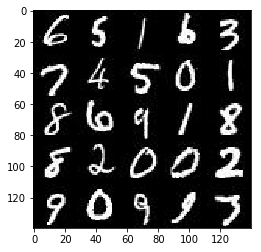

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

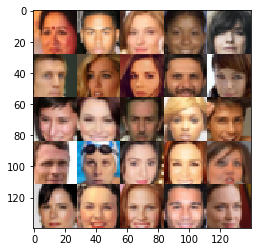

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image = tf.placeholder(tf.float32,[None, image_width, image_height, image_channels],name='input_real')
    Z = tf.placeholder(tf.float32, [None, z_dim],name='input_z')
    l_rate = tf.placeholder(tf.float32)

    return image, Z, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [77]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        images = tf.layers.dropout(images, rate=0.6)
        # input image is 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=1,padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        relu1 = tf.layers.dropout(relu1, rate=0.6)
        # 28*28*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, rate=0.6)
        # 14*14*256
         
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=0.6)
        # 7*7*256
               
        # dropout
        dropout = tf.nn.dropout(relu3, 0.6)
        
        #leaky Relu
        flat = tf.reshape(dropout, (-1, 7*7*256))
        logits = tf.layers.dense(flat,1,activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [78]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
               
        x4 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x256
        
        x5 = tf.layers.conv2d_transpose(x4, 128, 5, strides=1, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        # 14x14x128
        
        x6 = tf.layers.conv2d_transpose(x5, 64, 5, strides=1, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        x6 = tf.layers.batch_normalization(x6, training=is_train)
        x6 = tf.maximum(alpha * x6, x6)
        # 14x14x128
        
        

        # Output layer
        logits = tf.layers.conv2d_transpose(x6, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer = tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        
        out = tf.tanh(logits)
        
        return out 
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [79]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    # Smoothing 
    smooth = 0.8
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)) * (1 - smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [80]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [81]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [82]:
import sklearn.preprocessing
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    class GAN:
        def __init__(self, data_shape, z_dim, learning_rate):
        
            self.input_real, self.input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
            self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              data_shape[3])
        
            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
    

    net = GAN(data_shape, z_dim, learning_rate)

    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                #print(batch_images.shape)
                
                # normalize
                batch_images = batch_images*2
                    
                
                # TODO: Train Model
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})
                
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    

                if steps % 100 == 0:
                    show_generator_output(sess, 25, net.input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8087... Generator Loss: 0.3792
Epoch 1/2... Discriminator Loss: 1.4902... Generator Loss: 1.5715
Epoch 1/2... Discriminator Loss: 2.3474... Generator Loss: 0.4515
Epoch 1/2... Discriminator Loss: 1.8443... Generator Loss: 0.3828
Epoch 1/2... Discriminator Loss: 1.6418... Generator Loss: 0.4660
Epoch 1/2... Discriminator Loss: 1.3685... Generator Loss: 1.5054
Epoch 1/2... Discriminator Loss: 1.4651... Generator Loss: 2.8470
Epoch 1/2... Discriminator Loss: 0.8662... Generator Loss: 1.3690
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 0.7644... Generator Loss: 1.4716


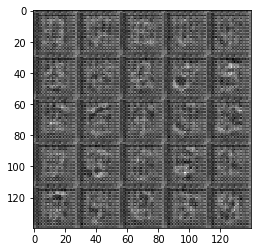

Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 0.6864
Epoch 1/2... Discriminator Loss: 0.5029... Generator Loss: 1.7527
Epoch 1/2... Discriminator Loss: 0.5575... Generator Loss: 1.6373
Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 0.5717
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.4300
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 0.5334
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 0.8183
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 0.5903
Epoch 1/2... Discriminator Loss: 1.7808... Generator Loss: 0.2239


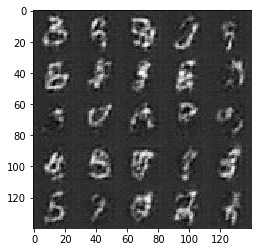

Epoch 1/2... Discriminator Loss: 0.5022... Generator Loss: 1.3315
Epoch 1/2... Discriminator Loss: 0.3252... Generator Loss: 1.6537
Epoch 1/2... Discriminator Loss: 0.2601... Generator Loss: 2.1446
Epoch 1/2... Discriminator Loss: 4.7208... Generator Loss: 8.0958
Epoch 1/2... Discriminator Loss: 0.9663... Generator Loss: 0.6509
Epoch 1/2... Discriminator Loss: 0.9482... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 0.9441
Epoch 1/2... Discriminator Loss: 1.9102... Generator Loss: 0.2440
Epoch 1/2... Discriminator Loss: 1.0391... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 0.5258... Generator Loss: 1.3870


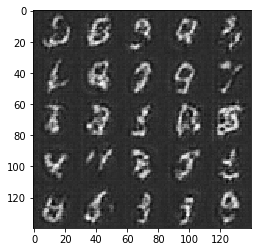

Epoch 1/2... Discriminator Loss: 0.4598... Generator Loss: 3.0903
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 1.3098... Generator Loss: 0.9091
Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 0.9027
Epoch 1/2... Discriminator Loss: 0.7456... Generator Loss: 1.0895
Epoch 1/2... Discriminator Loss: 0.6632... Generator Loss: 1.3067
Epoch 1/2... Discriminator Loss: 0.5391... Generator Loss: 1.1243
Epoch 1/2... Discriminator Loss: 0.3972... Generator Loss: 1.4957
Epoch 1/2... Discriminator Loss: 0.6244... Generator Loss: 1.0468
Epoch 1/2... Discriminator Loss: 0.1711... Generator Loss: 2.4255


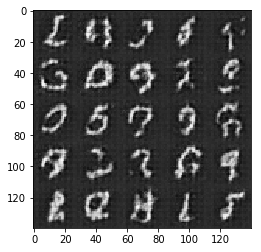

Epoch 1/2... Discriminator Loss: 0.2892... Generator Loss: 1.9239
Epoch 1/2... Discriminator Loss: 2.5580... Generator Loss: 6.0150
Epoch 1/2... Discriminator Loss: 1.0385... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 1.0408
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.3785
Epoch 1/2... Discriminator Loss: 0.4408... Generator Loss: 2.4768
Epoch 1/2... Discriminator Loss: 0.2823... Generator Loss: 2.6252
Epoch 1/2... Discriminator Loss: 0.2852... Generator Loss: 1.9021
Epoch 1/2... Discriminator Loss: 0.1030... Generator Loss: 4.6782
Epoch 1/2... Discriminator Loss: 0.6746... Generator Loss: 1.2235


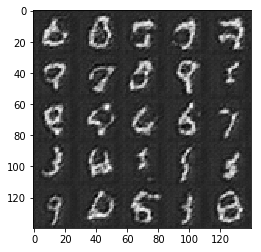

Epoch 1/2... Discriminator Loss: 0.6369... Generator Loss: 1.1085
Epoch 1/2... Discriminator Loss: 0.5646... Generator Loss: 1.1779
Epoch 1/2... Discriminator Loss: 0.8003... Generator Loss: 0.7867
Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 0.3566... Generator Loss: 1.6416
Epoch 1/2... Discriminator Loss: 0.2386... Generator Loss: 1.9981
Epoch 1/2... Discriminator Loss: 0.3660... Generator Loss: 1.5338
Epoch 1/2... Discriminator Loss: 3.3638... Generator Loss: 0.0545
Epoch 1/2... Discriminator Loss: 0.9455... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 1.7004


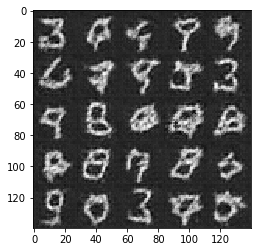

Epoch 1/2... Discriminator Loss: 0.7184... Generator Loss: 2.0891
Epoch 1/2... Discriminator Loss: 0.5478... Generator Loss: 1.1329
Epoch 1/2... Discriminator Loss: 0.6086... Generator Loss: 1.2286
Epoch 1/2... Discriminator Loss: 0.2731... Generator Loss: 1.9925
Epoch 1/2... Discriminator Loss: 0.1849... Generator Loss: 3.8385
Epoch 1/2... Discriminator Loss: 0.6210... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.3876
Epoch 1/2... Discriminator Loss: 0.6595... Generator Loss: 1.7444
Epoch 1/2... Discriminator Loss: 0.6299... Generator Loss: 1.1522
Epoch 1/2... Discriminator Loss: 0.4656... Generator Loss: 1.2401


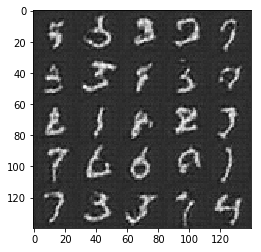

Epoch 1/2... Discriminator Loss: 0.8198... Generator Loss: 5.8596
Epoch 1/2... Discriminator Loss: 0.4505... Generator Loss: 1.2112
Epoch 1/2... Discriminator Loss: 0.4334... Generator Loss: 1.4263
Epoch 1/2... Discriminator Loss: 0.0869... Generator Loss: 3.8456
Epoch 1/2... Discriminator Loss: 2.2785... Generator Loss: 5.4750
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.2313
Epoch 1/2... Discriminator Loss: 0.7325... Generator Loss: 1.8299
Epoch 1/2... Discriminator Loss: 1.6357... Generator Loss: 5.1255
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.3820
Epoch 1/2... Discriminator Loss: 0.2814... Generator Loss: 1.6707


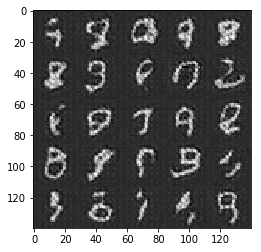

Epoch 1/2... Discriminator Loss: 0.3828... Generator Loss: 1.5077
Epoch 1/2... Discriminator Loss: 0.0430... Generator Loss: 4.5793
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 7.3756
Epoch 1/2... Discriminator Loss: 0.6872... Generator Loss: 0.9462
Epoch 1/2... Discriminator Loss: 1.6699... Generator Loss: 4.1229
Epoch 1/2... Discriminator Loss: 0.6116... Generator Loss: 1.4407
Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 1.0564
Epoch 1/2... Discriminator Loss: 0.5651... Generator Loss: 1.1527
Epoch 1/2... Discriminator Loss: 0.7692... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 0.3879... Generator Loss: 1.4231


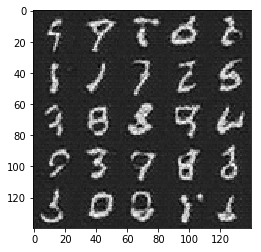

Epoch 1/2... Discriminator Loss: 0.4173... Generator Loss: 1.4078
Epoch 1/2... Discriminator Loss: 0.4514... Generator Loss: 1.8007
Epoch 1/2... Discriminator Loss: 0.1017... Generator Loss: 3.1880
Epoch 2/2... Discriminator Loss: 0.3199... Generator Loss: 1.6676
Epoch 2/2... Discriminator Loss: 0.2463... Generator Loss: 1.9974
Epoch 2/2... Discriminator Loss: 0.2393... Generator Loss: 1.8165
Epoch 2/2... Discriminator Loss: 0.0859... Generator Loss: 7.4864
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.5877
Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 1.6429
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 0.9798


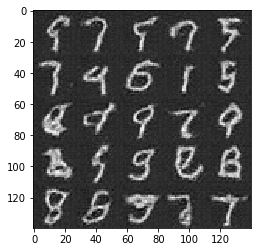

Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 0.7101
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 3.8855
Epoch 2/2... Discriminator Loss: 1.5167... Generator Loss: 4.7592
Epoch 2/2... Discriminator Loss: 0.8636... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 0.6569... Generator Loss: 1.2424
Epoch 2/2... Discriminator Loss: 1.0146... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 0.1914... Generator Loss: 3.9406
Epoch 2/2... Discriminator Loss: 0.3477... Generator Loss: 2.9876
Epoch 2/2... Discriminator Loss: 0.2001... Generator Loss: 2.2958


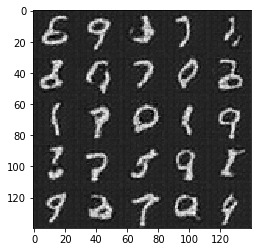

Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 0.5182... Generator Loss: 1.5745
Epoch 2/2... Discriminator Loss: 0.6363... Generator Loss: 1.0640
Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 1.0679
Epoch 2/2... Discriminator Loss: 0.4029... Generator Loss: 1.6307
Epoch 2/2... Discriminator Loss: 0.0766... Generator Loss: 5.9111
Epoch 2/2... Discriminator Loss: 0.2382... Generator Loss: 2.5265
Epoch 2/2... Discriminator Loss: 0.0802... Generator Loss: 4.0698
Epoch 2/2... Discriminator Loss: 0.1088... Generator Loss: 5.1480
Epoch 2/2... Discriminator Loss: 4.2522... Generator Loss: 9.0062


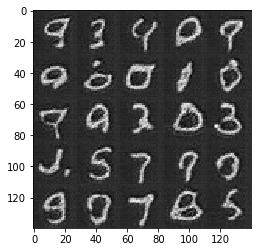

Epoch 2/2... Discriminator Loss: 0.2623... Generator Loss: 1.9852
Epoch 2/2... Discriminator Loss: 0.5241... Generator Loss: 2.5181
Epoch 2/2... Discriminator Loss: 0.3121... Generator Loss: 2.6529
Epoch 2/2... Discriminator Loss: 0.1205... Generator Loss: 3.3516
Epoch 2/2... Discriminator Loss: 0.4028... Generator Loss: 1.4695
Epoch 2/2... Discriminator Loss: 0.1131... Generator Loss: 3.0826
Epoch 2/2... Discriminator Loss: 0.1257... Generator Loss: 3.0881
Epoch 2/2... Discriminator Loss: 0.1849... Generator Loss: 2.4982
Epoch 2/2... Discriminator Loss: 1.0553... Generator Loss: 0.7387
Epoch 2/2... Discriminator Loss: 0.5745... Generator Loss: 1.6009


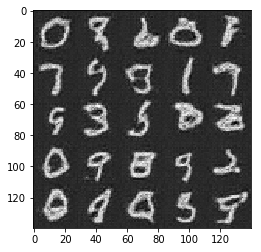

Epoch 2/2... Discriminator Loss: 0.6114... Generator Loss: 1.5670
Epoch 2/2... Discriminator Loss: 0.5774... Generator Loss: 1.3628
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 0.7816
Epoch 2/2... Discriminator Loss: 0.3034... Generator Loss: 1.7891
Epoch 2/2... Discriminator Loss: 0.8257... Generator Loss: 1.1537
Epoch 2/2... Discriminator Loss: 0.3155... Generator Loss: 2.2689
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.2611
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: 0.2599... Generator Loss: 2.6702
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.1866


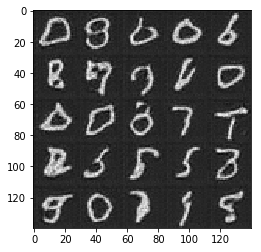

Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.5848
Epoch 2/2... Discriminator Loss: 0.2123... Generator Loss: 2.8909
Epoch 2/2... Discriminator Loss: 0.2691... Generator Loss: 2.9382
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.4630
Epoch 2/2... Discriminator Loss: 0.6035... Generator Loss: 1.3354
Epoch 2/2... Discriminator Loss: 0.5869... Generator Loss: 1.2910
Epoch 2/2... Discriminator Loss: 0.3247... Generator Loss: 2.5019
Epoch 2/2... Discriminator Loss: 1.4205... Generator Loss: 0.3915
Epoch 2/2... Discriminator Loss: 0.5867... Generator Loss: 1.3373
Epoch 2/2... Discriminator Loss: 0.4879... Generator Loss: 1.6073


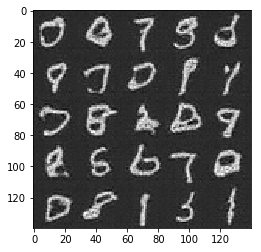

Epoch 2/2... Discriminator Loss: 0.3901... Generator Loss: 1.6777
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 0.4242
Epoch 2/2... Discriminator Loss: 0.4455... Generator Loss: 1.3209
Epoch 2/2... Discriminator Loss: 0.2213... Generator Loss: 2.3484
Epoch 2/2... Discriminator Loss: 0.2757... Generator Loss: 2.0925
Epoch 2/2... Discriminator Loss: 0.1418... Generator Loss: 3.8417
Epoch 2/2... Discriminator Loss: 0.4648... Generator Loss: 1.2113
Epoch 2/2... Discriminator Loss: 0.6856... Generator Loss: 1.4229
Epoch 2/2... Discriminator Loss: 0.5493... Generator Loss: 1.4560
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 0.6519


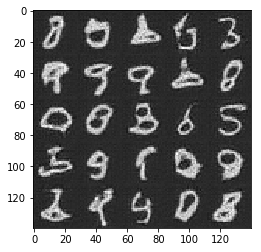

Epoch 2/2... Discriminator Loss: 0.5205... Generator Loss: 1.7118
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 0.5647
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 0.9586
Epoch 2/2... Discriminator Loss: 0.2894... Generator Loss: 1.8901
Epoch 2/2... Discriminator Loss: 1.2641... Generator Loss: 3.0903
Epoch 2/2... Discriminator Loss: 0.5699... Generator Loss: 1.2865
Epoch 2/2... Discriminator Loss: 0.6907... Generator Loss: 1.0586
Epoch 2/2... Discriminator Loss: 0.3139... Generator Loss: 2.1479
Epoch 2/2... Discriminator Loss: 0.7656... Generator Loss: 0.9284
Epoch 2/2... Discriminator Loss: 0.4085... Generator Loss: 2.1868


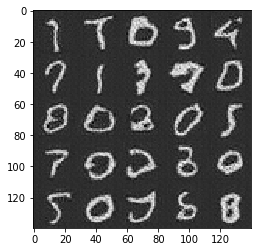

Epoch 2/2... Discriminator Loss: 0.4863... Generator Loss: 1.4244
Epoch 2/2... Discriminator Loss: 0.5736... Generator Loss: 1.2608
Epoch 2/2... Discriminator Loss: 0.0893... Generator Loss: 4.1240
Epoch 2/2... Discriminator Loss: 0.3971... Generator Loss: 1.5376
Epoch 2/2... Discriminator Loss: 1.2552... Generator Loss: 0.6428
Epoch 2/2... Discriminator Loss: 0.5791... Generator Loss: 1.9057
Epoch 2/2... Discriminator Loss: 1.5019... Generator Loss: 0.4351
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.4553
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 1.8796
Epoch 2/2... Discriminator Loss: 0.6614... Generator Loss: 1.0053


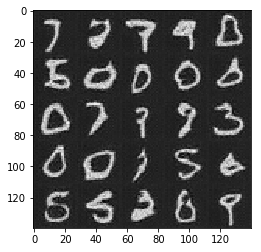

Epoch 2/2... Discriminator Loss: 0.5539... Generator Loss: 1.2810
Epoch 2/2... Discriminator Loss: 0.6735... Generator Loss: 1.1494
Epoch 2/2... Discriminator Loss: 0.3958... Generator Loss: 1.8007
Epoch 2/2... Discriminator Loss: 0.3250... Generator Loss: 1.8217
Epoch 2/2... Discriminator Loss: 0.9165... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 1.1281
Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 0.7475


In [27]:
batch_size = 64
z_dim = 100
learning_rate =  0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
        

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4145... Generator Loss: 0.2679
Epoch 1/1... Discriminator Loss: 2.2843... Generator Loss: 0.3077
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 3.8351
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 8.2214
Epoch 1/1... Discriminator Loss: 1.7006... Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 1.8934... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 2.0372
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.5795
Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.9785
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.3716


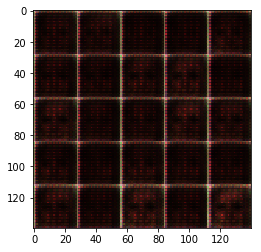

Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.4751
Epoch 1/1... Discriminator Loss: 0.8236... Generator Loss: 1.7946
Epoch 1/1... Discriminator Loss: 0.7733... Generator Loss: 1.6961
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.7665
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 1.9513
Epoch 1/1... Discriminator Loss: 0.7265... Generator Loss: 1.7782
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 1.6102
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 1.3540
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.7338
Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 1.8423


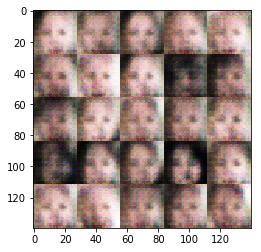

Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.8112
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 1.7677
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.5329
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 1.9719
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 1.9948
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.6429
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 1.8355
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.9826
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 1.6912
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 1.8384


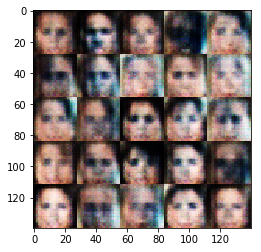

Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 1.8168
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 2.2475
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.6737
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.8673
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 1.6490
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 2.8987
Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 1.5345
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.6194
Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 1.8901
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 1.6168


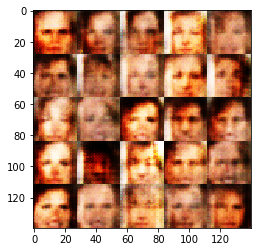

Epoch 1/1... Discriminator Loss: 0.6330... Generator Loss: 3.2294
Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 2.1222
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 2.1100
Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 2.0918
Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 1.5332
Epoch 1/1... Discriminator Loss: 0.6761... Generator Loss: 3.7201
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 2.3490
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 3.0266
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 2.7705
Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 2.8912


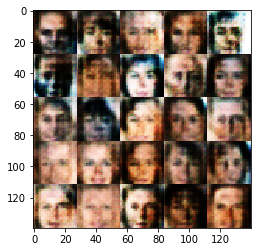

Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 2.1629
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 2.0783
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 1.3728
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 2.6911
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 3.9518
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 1.7110
Epoch 1/1... Discriminator Loss: 0.5912... Generator Loss: 2.0218
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 1.6559
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 2.3372
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 1.6498


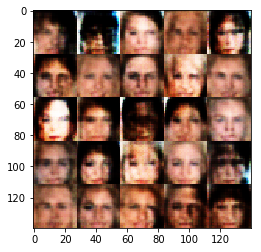

Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 1.4924
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 2.3004
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 2.3487
Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 2.8991
Epoch 1/1... Discriminator Loss: 0.5798... Generator Loss: 1.9394
Epoch 1/1... Discriminator Loss: 0.4756... Generator Loss: 2.6392
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 2.2284
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 2.9367
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 2.6161
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.2200


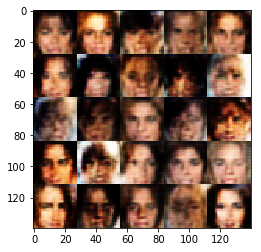

Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 1.7277
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 2.7443
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 2.3274
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 1.7242
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 2.1733
Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 2.0791
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 2.3859
Epoch 1/1... Discriminator Loss: 0.6101... Generator Loss: 1.8040
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 2.3065
Epoch 1/1... Discriminator Loss: 0.5742... Generator Loss: 1.5825


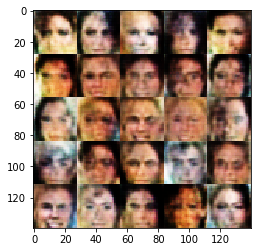

Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 1.2733
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 2.0797
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 1.4232
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 4.2735
Epoch 1/1... Discriminator Loss: 0.6247... Generator Loss: 1.7996
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 1.8363
Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 1.8612
Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 2.9191
Epoch 1/1... Discriminator Loss: 0.5249... Generator Loss: 2.3287
Epoch 1/1... Discriminator Loss: 0.4940... Generator Loss: 1.8630


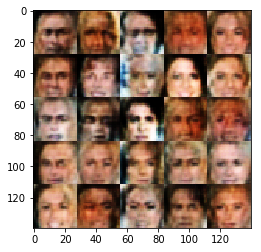

Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 2.1436
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 1.2450
Epoch 1/1... Discriminator Loss: 0.5933... Generator Loss: 1.4605
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.2548
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 3.3557
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 1.7833
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.2300
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 2.1189


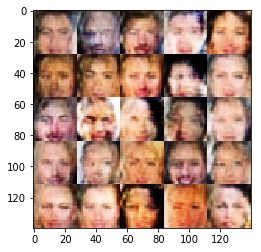

Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 1.5580
Epoch 1/1... Discriminator Loss: 0.5291... Generator Loss: 2.3190
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 2.1959
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 1.5766
Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 1.9678
Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 1.9433
Epoch 1/1... Discriminator Loss: 0.5713... Generator Loss: 1.8366
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 2.5090
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 1.8187


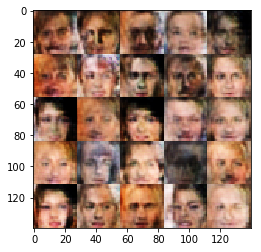

Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 1.4849
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 2.1221
Epoch 1/1... Discriminator Loss: 0.5870... Generator Loss: 2.2394
Epoch 1/1... Discriminator Loss: 0.5708... Generator Loss: 1.9272
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 2.2818
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 1.9780
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 1.5571
Epoch 1/1... Discriminator Loss: 0.6690... Generator Loss: 2.4004
Epoch 1/1... Discriminator Loss: 0.5695... Generator Loss: 1.6709
Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 1.4817


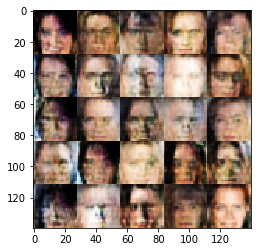

Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 2.6064
Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 1.6780
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 1.6874
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.6591
Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 2.6353
Epoch 1/1... Discriminator Loss: 0.4462... Generator Loss: 2.7517
Epoch 1/1... Discriminator Loss: 0.1177... Generator Loss: 5.7936
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 2.9022
Epoch 1/1... Discriminator Loss: 0.6923... Generator Loss: 1.9058
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.6538


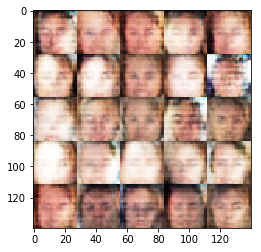

Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.8827
Epoch 1/1... Discriminator Loss: 0.5622... Generator Loss: 1.8633
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 1.8210
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 1.7651
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 2.3933
Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 2.3001
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 1.6808
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 1.7674
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.4433
Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 2.3606


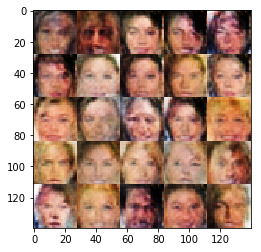

Epoch 1/1... Discriminator Loss: 0.5117... Generator Loss: 1.7174
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 1.9670
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 1.8718
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 2.2189
Epoch 1/1... Discriminator Loss: 0.5742... Generator Loss: 1.5339
Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 1.5271
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 2.4913
Epoch 1/1... Discriminator Loss: 0.5468... Generator Loss: 1.5613
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 2.1609


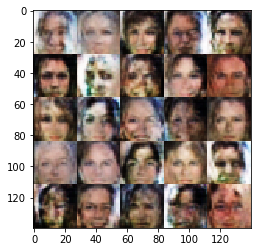

Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 1.9817
Epoch 1/1... Discriminator Loss: 0.5287... Generator Loss: 2.5191
Epoch 1/1... Discriminator Loss: 0.5211... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 3.0889
Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 2.2156
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 1.1722
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 2.2686
Epoch 1/1... Discriminator Loss: 0.2315... Generator Loss: 3.2653
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 1.5039


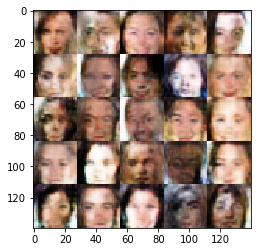

Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 1.9769
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 2.2780
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 2.4919
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 1.8561
Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 2.2128
Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 1.6556
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 1.7810
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 1.4484
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 2.6072
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 2.9288


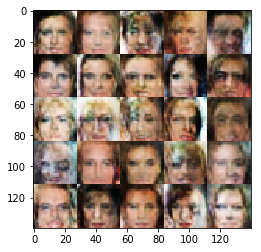

Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 3.1250
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 2.1594
Epoch 1/1... Discriminator Loss: 0.3067... Generator Loss: 2.8831
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 2.6715
Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 2.7625
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 2.1039
Epoch 1/1... Discriminator Loss: 0.5547... Generator Loss: 1.6171
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 2.2146
Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 2.0674
Epoch 1/1... Discriminator Loss: 0.6462... Generator Loss: 1.4610


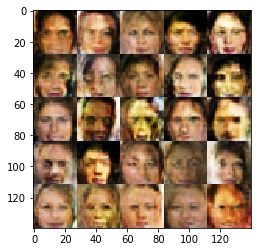

Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 1.4522
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 3.7054
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 5.3436
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 2.6732
Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 1.7439
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 1.6312
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 1.9393
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 1.6388
Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 2.3549


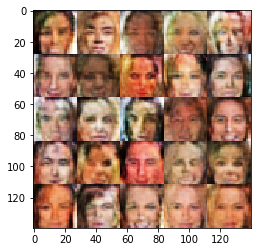

Epoch 1/1... Discriminator Loss: 0.3617... Generator Loss: 1.7924
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 5.9585
Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 1.5240
Epoch 1/1... Discriminator Loss: 0.5289... Generator Loss: 2.2161
Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 2.7258
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 1.8880
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 2.8632
Epoch 1/1... Discriminator Loss: 0.5247... Generator Loss: 1.5755
Epoch 1/1... Discriminator Loss: 0.1999... Generator Loss: 4.1247
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 2.1753


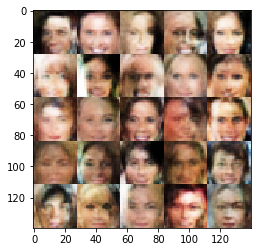

Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 2.0983
Epoch 1/1... Discriminator Loss: 0.4434... Generator Loss: 3.1217
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.3421
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 1.9137
Epoch 1/1... Discriminator Loss: 0.1598... Generator Loss: 3.9126
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 2.0960
Epoch 1/1... Discriminator Loss: 0.1064... Generator Loss: 6.5836
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 1.8726
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 1.4973
Epoch 1/1... Discriminator Loss: 0.1423... Generator Loss: 3.8231


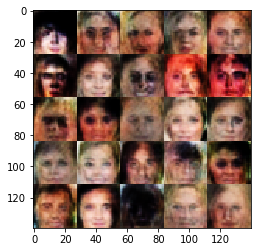

Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 3.2551
Epoch 1/1... Discriminator Loss: 0.5212... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 0.2530... Generator Loss: 4.8153
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.3727
Epoch 1/1... Discriminator Loss: 0.3513... Generator Loss: 1.6530
Epoch 1/1... Discriminator Loss: 0.2383... Generator Loss: 3.7746
Epoch 1/1... Discriminator Loss: 0.3468... Generator Loss: 2.7070
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 1.5471
Epoch 1/1... Discriminator Loss: 0.1644... Generator Loss: 2.4883


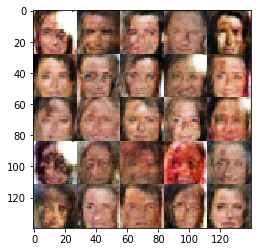

Epoch 1/1... Discriminator Loss: 0.2114... Generator Loss: 2.0779
Epoch 1/1... Discriminator Loss: 0.2390... Generator Loss: 2.0642
Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 2.8717
Epoch 1/1... Discriminator Loss: 0.2326... Generator Loss: 6.0219
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 2.7187
Epoch 1/1... Discriminator Loss: 0.3721... Generator Loss: 1.9327
Epoch 1/1... Discriminator Loss: 0.2234... Generator Loss: 5.0402
Epoch 1/1... Discriminator Loss: 0.5701... Generator Loss: 1.4428
Epoch 1/1... Discriminator Loss: 0.1671... Generator Loss: 2.2891


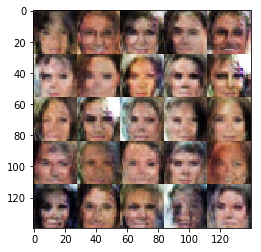

Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 7.2020
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 5.4236
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 1.8054
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 2.1108
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 2.0655
Epoch 1/1... Discriminator Loss: 0.5885... Generator Loss: 2.9661
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 2.7648
Epoch 1/1... Discriminator Loss: 0.3032... Generator Loss: 2.9756
Epoch 1/1... Discriminator Loss: 0.2915... Generator Loss: 5.5450
Epoch 1/1... Discriminator Loss: 0.2420... Generator Loss: 2.5467


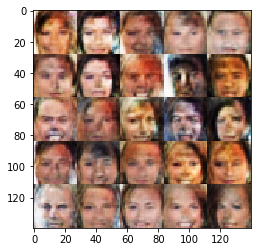

Epoch 1/1... Discriminator Loss: 0.2849... Generator Loss: 3.3776
Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 1.5225
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 0.0710... Generator Loss: 5.7214
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 5.3624
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 1.7520
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 0.3732... Generator Loss: 2.2888
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 3.6454


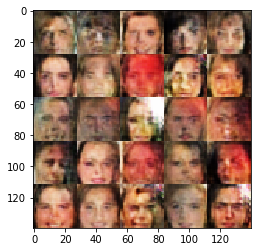

Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 7.1860
Epoch 1/1... Discriminator Loss: 0.3360... Generator Loss: 1.8043
Epoch 1/1... Discriminator Loss: 0.6623... Generator Loss: 2.2960
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 2.6581
Epoch 1/1... Discriminator Loss: 0.5767... Generator Loss: 1.7649
Epoch 1/1... Discriminator Loss: 0.2891... Generator Loss: 6.2559
Epoch 1/1... Discriminator Loss: 0.4494... Generator Loss: 4.7271
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 5.4873


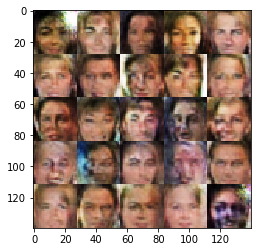

Epoch 1/1... Discriminator Loss: 0.2458... Generator Loss: 2.5145
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 3.8108
Epoch 1/1... Discriminator Loss: 0.2813... Generator Loss: 3.1998
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 1.4771
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 3.9957
Epoch 1/1... Discriminator Loss: 0.3146... Generator Loss: 1.6901
Epoch 1/1... Discriminator Loss: 0.3043... Generator Loss: 4.6458
Epoch 1/1... Discriminator Loss: 0.4373... Generator Loss: 4.7349
Epoch 1/1... Discriminator Loss: 0.1951... Generator Loss: 5.3402


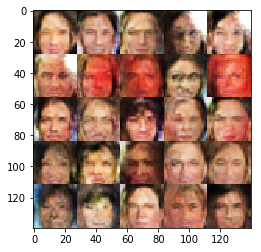

Epoch 1/1... Discriminator Loss: 0.3053... Generator Loss: 7.0596
Epoch 1/1... Discriminator Loss: 0.0921... Generator Loss: 4.9453
Epoch 1/1... Discriminator Loss: 0.1407... Generator Loss: 5.7867
Epoch 1/1... Discriminator Loss: 0.2962... Generator Loss: 1.8279
Epoch 1/1... Discriminator Loss: 0.2987... Generator Loss: 4.2970
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 5.0759
Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 6.4223
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 2.1950
Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 1.7662
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 2.6143


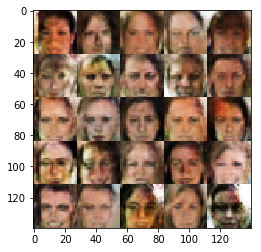

Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 7.5150
Epoch 1/1... Discriminator Loss: 0.1277... Generator Loss: 3.8100
Epoch 1/1... Discriminator Loss: 0.4159... Generator Loss: 1.5741
Epoch 1/1... Discriminator Loss: 0.1931... Generator Loss: 2.2823
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 0.1989... Generator Loss: 3.9728
Epoch 1/1... Discriminator Loss: 0.2367... Generator Loss: 8.8217
Epoch 1/1... Discriminator Loss: 0.2587... Generator Loss: 5.3134
Epoch 1/1... Discriminator Loss: 0.1758... Generator Loss: 2.3465
Epoch 1/1... Discriminator Loss: 0.0733... Generator Loss: 7.3298


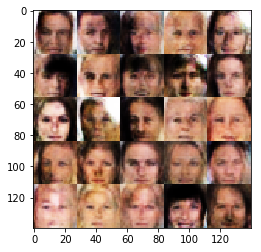

Epoch 1/1... Discriminator Loss: 0.5740... Generator Loss: 1.1516
Epoch 1/1... Discriminator Loss: 0.1963... Generator Loss: 2.6694
Epoch 1/1... Discriminator Loss: 0.0432... Generator Loss: 4.4622
Epoch 1/1... Discriminator Loss: 0.0246... Generator Loss: 6.0411
Epoch 1/1... Discriminator Loss: 0.2135... Generator Loss: 2.1912
Epoch 1/1... Discriminator Loss: 0.5637... Generator Loss: 11.5295
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 0.0680... Generator Loss: 4.8005
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 2.8773
Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 2.2612


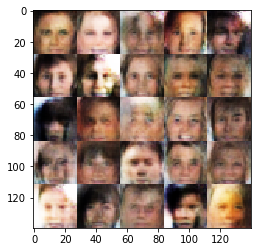

Epoch 1/1... Discriminator Loss: 0.6106... Generator Loss: 1.8075
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 1.4097
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 1.8012
Epoch 1/1... Discriminator Loss: 0.1731... Generator Loss: 2.8472
Epoch 1/1... Discriminator Loss: 0.3121... Generator Loss: 1.9599
Epoch 1/1... Discriminator Loss: 0.0831... Generator Loss: 5.6381
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 1.6944
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 2.0330
Epoch 1/1... Discriminator Loss: 0.2351... Generator Loss: 2.1514


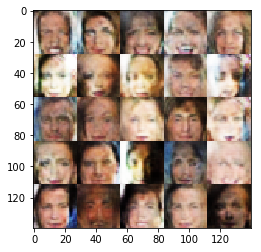

Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 3.8755
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 1.7404
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 2.4068
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 0.2133... Generator Loss: 2.8508
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 1.4396


In [83]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.